# Data Generation

A synthetic employee dataset was generated to simulate normal and anomalous employee behavior. The dataset includes employee role, department, salary, and overtime hours. Anomalies were intentionally injected by assigning unusually high salaries and excessive overtime hours to a small fraction of the records. This approach enables controlled evaluation of anomaly detection models in an unsupervised learning setting.

In [59]:
import numpy as np
import pandas as pd

def generate_employee_data(n_samples=1000, anomaly_ratio=0.05):
    # np.random.seed(42)

    roles = ['Intern', 'Junior', 'Senior']
    departments = ['IT', 'HR']

    base_salary = {
        'Intern': 30000,
        'Junior': 50000,
        'Senior': 80000
    }

    data = []
    n_anomalies = int(n_samples * anomaly_ratio)

    for i in range(n_samples):
        role = np.random.choice(roles)
        dept = np.random.choice(departments)

        salary = np.random.normal(base_salary[role], 4000)
        overtime = max(0, np.random.normal(10, 4))
        label = 0

        if i < n_anomalies:
            salary = base_salary[role] * 2
            overtime = np.random.normal(100, 10)
            label = 1

        data.append([role, dept, salary, overtime, label])

    return pd.DataFrame(
        data,
        columns=['role', 'department', 'salary', 'overtime_hours', 'is_anomaly']
    )

data = generate_employee_data()
data.to_csv('employee_data.csv', index=False)


# 2. Data Loading and Initial Exploration
The generated dataset was loaded into a Pandas DataFrame for analysis. Initial exploration was performed to verify class distribution and confirm the presence of anomalies. Since anomaly detection typically involves highly imbalanced data, only a small percentage of records were labeled as anomalies.

In [60]:
df = pd.read_csv('employee_data.csv')

print(df.head())
df.groupby('is_anomaly').count()


     role department    salary  overtime_hours  is_anomaly
0  Senior         IT  160000.0       95.543497           1
1  Senior         IT  160000.0       97.830850           1
2  Intern         HR   60000.0      108.511241           1
3  Senior         IT  160000.0       84.504189           1
4  Senior         HR  160000.0       95.549327           1


,role,department,salary,overtime_hours
is_anomaly,,,,
0,950,950,950,950
1,50,50,50,50


# 3. Data Preprocessing
<h4>  3.1 Categorical Encoding</h4>
since machine learning models require numerical inputs, categorical features such as employee role and department were converted into numeric form using Label Encoding.

In [61]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['role'] = le.fit_transform(df['role'])
df['department'] = le.fit_transform(df['department'])


<h4>3.2 Feature Scaling</h4>
Feature scaling was applied using StandardScaler to normalize salary and overtime values. This ensures that all numerical features contribute equally to distance-based anomaly detection models such as Isolation Forest.

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['salary', 'overtime_hours']] = scaler.fit_transform(
    df[['salary', 'overtime_hours']]
)


# 4. Data Visualization
Pairwise feature visualization was performed to analyze the separation between normal and anomalous data points. The visual inspection shows that anomalies exhibit significantly higher salary and overtime values compared to normal employees.

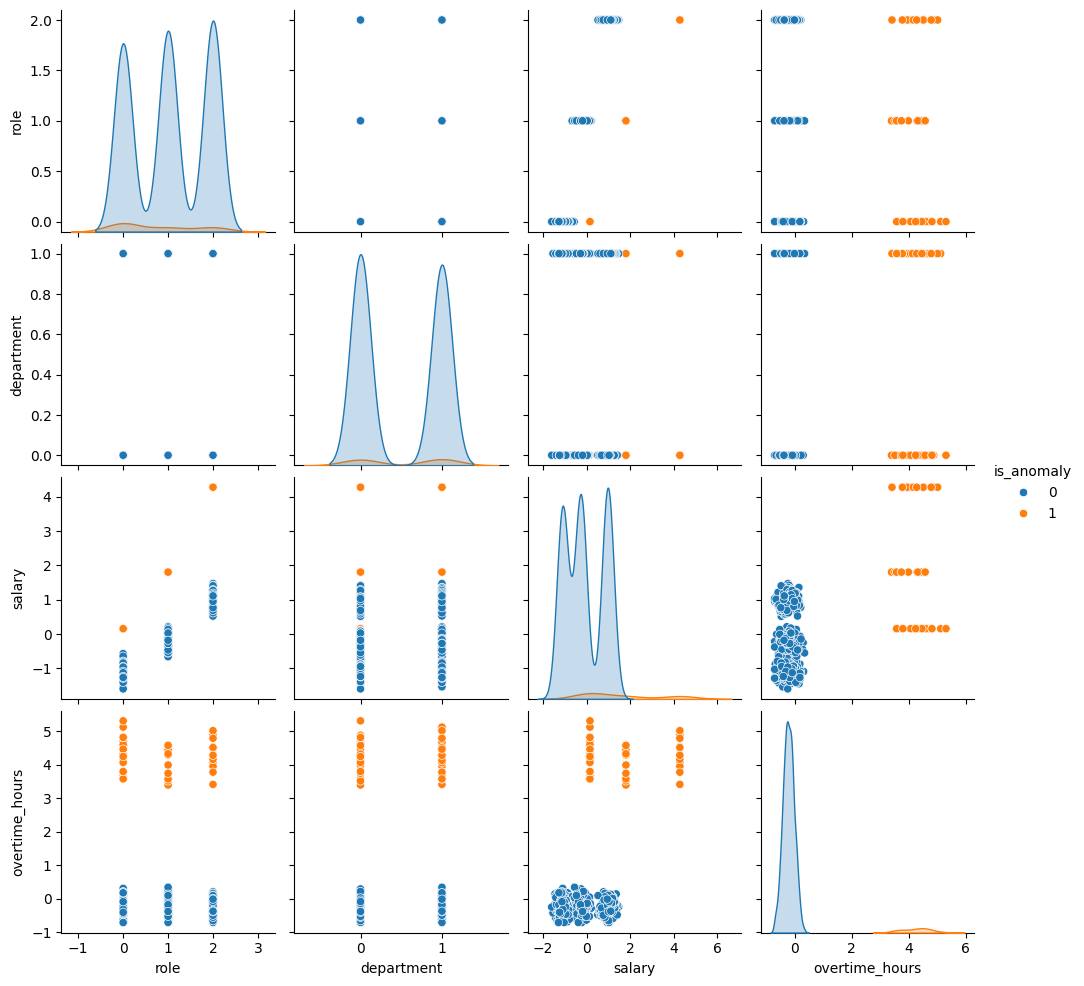

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, hue='is_anomaly')
plt.show()


# 5. Train–Test Split

The dataset was split into training and testing sets using an 80–20 ratio. Although Isolation Forest is an unsupervised algorithm, labeled data was retained only for evaluation purposes.

In [64]:
from sklearn.model_selection import train_test_split

X = df.drop('is_anomaly', axis=1)
y = df['is_anomaly']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 6. Model Training (Isolation Forest)
Isolation Forest was selected for anomaly detection due to its effectiveness in identifying rare and irregular patterns. The contamination parameter was set based on the known proportion of anomalies in the dataset.

In [65]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_train)


IsolationForest(contamination=0.05, random_state=42)

# 7. Prediction and Label Conversion

Isolation Forest outputs predictions in the form of -1 for anomalies and 1 for normal instances. These values were converted into binary labels to align with the ground truth for evaluation.


In [66]:
import numpy as np

y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test == 1, 0, 1)

y_pred = model.predict(X)
y_pred = np.where(y_pred == 1, 0, 1)


# 8. Model Evaluation
The model achieved high accuracy indicating effective separation of anomalous and normal employee records. The confusion matrix further confirms that anomalies were correctly detected with minimal false positives.

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


1.0
[[194   0]
 [  0   6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       194
           1       1.00      1.00      1.00         6

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



# 9. Anomaly Index Identification
The indices of detected anomalous records were extracted for further investigation. This enables organizations to review specific employee records flagged as suspicious.

In [68]:
anomaly_indices = np.where(y_pred_test == 1)[0]
print(anomaly_indices)


[ 54  55  57  77 138 140]


# 10. Key Observation 

The perfect test accuracy is a result of synthetically generated anomalies with clear separation. In real-world datasets, performance is expected to be lower due to overlapping patterns, noise, and unknown anomaly distributions.

# 11. finding anamoly from whole dataset

In [69]:
print(accuracy_score(y, y_pred))
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))




0.996
[[950   0]
 [  4  46]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       950
           1       1.00      0.92      0.96        50

    accuracy                           1.00      1000
   macro avg       1.00      0.96      0.98      1000
weighted avg       1.00      1.00      1.00      1000



In [74]:
anomaly_indices = np.where(y_pred == 1)[0]

print("NO of Anomaly indeces predicted : ",len(anomaly_indices))
print("anomaly indeses are : \n" ,anomaly_indices)

NO of Anomaly indeces predicted :  46
anomaly indeses are : 
 [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47 48 49]
